In [1]:
import random
import time
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import requests
import json
import os

In [26]:
# Replace with your Azure OpenAI endpoint and API key
endpoint = os.getenv("MY_GTP4OMINI_ENDPOINT")


api_key = os.getenv("MY_GPT4OMINI_KEY")

# Define the headers
headers = {
    'Content-Type': 'application/json',
    'api-key': api_key
}


In [23]:
def get_response(user_prompt, system_prompt):
    data = {
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ]
    }
    
    # Make the POST request to the Azure OpenAI API
    response = requests.post(endpoint, headers=headers, data=json.dumps(data))
    
    # Check for a successful response
    if response.status_code == 200:
        result = response.json()
        return result['choices'][0]['message']['content']
    else:
        print(f"Error: {response.status_code}")
        print(response.text)
        return None

In [22]:
def llm_decision(state, world_size):
    system_prompt = f"""
Imagine you are a living organism living in a grid {world_size} by {world_size}.
Your position is denoted by X and the food is denoted by F. You can move only up/down or left/right. Your goal is to reach that food.
Make a decision where to move and always reply only with one word! Choose from this array:
['up', 'down', 'left', 'right']"""

    user_prompt = f"""
What is your next step for this grid below?

{state}

"""
    decision = get_response(user_prompt, system_prompt)
    return decision

KeyboardInterrupt: 

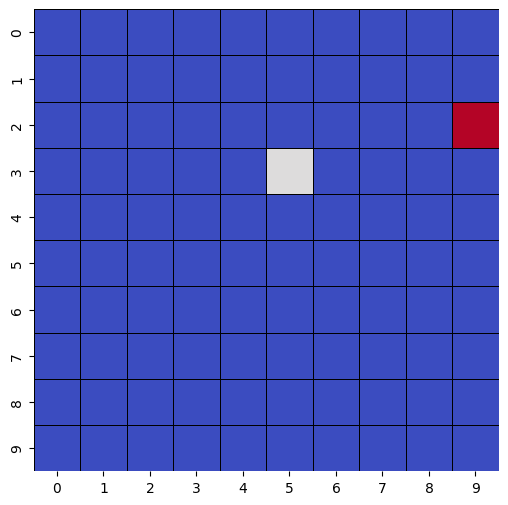

In [32]:
class GridWorld:
    # a simple grid world
    def __init__(self, size):
        self.size = size
        self.grid = np.zeros((size, size))
        self.position = (size // 2, size // 2)
        self.grid[self.position[0]][self.position[1]] = 1  # X represented by 1
        self.food_position = self.place_food()
        self.grid[self.food_position[0]][self.food_position[1]] = 2  # F represented by 2

    def place_food(self):
        while True:
            food_position = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
            if food_position != self.position:
                return food_position

    def display_grid(self, frame_ix):
        plt.figure(figsize=(6, 6))
        sns.heatmap(self.grid, cbar=False, cmap="coolwarm", linewidths=.5, linecolor='black', annot=False, fmt='.0f', annot_kws={"size": 18})
        plt.axis('off')
        # save as a png
        plt.savefig(f'frames/frame_{j}.png', dpi=300, bbox_inches='tight')
        plt.close()

    def move(self, direction):
        x, y = self.position
        self.grid[x][y] = 0  # Clear current position

        if direction == 'up' and x > 0:
            x -= 1
        elif direction == 'down' and x < self.size - 1:
            x += 1
        elif direction == 'left' and y > 0:
            y -= 1
        elif direction == 'right' and y < self.size - 1:
            y += 1

        self.position = (x, y)
        self.grid[x][y] = 1  # Mark new position with 1

    def is_food_reached(self):
        return self.position == self.food_position

    def get_state_for_llm(self):
        state = ""
        for i in range(self.size):
            for j in range(self.size):
                if (i, j) == self.position:
                    state += "X "
                elif (i, j) == self.food_position:
                    state += "F "
                else:
                    state += "0 "
            state = state.strip() + "\n"
        return state.strip()



# Initialize the grid world
size = 10


# Simulate movements
j = 0
for _ in range(10):
    world = GridWorld(size)
    while not world.is_food_reached():
        clear_output(wait=True)
        state = world.get_state_for_llm()
        #print("Current State:\n" + state)
        decision = llm_decision(state, world_size=size)
        world.move(decision)
        world.display_grid(frame_ix=j)
        j += 1